In [2]:
import pandas as pd
import numpy as np
import nltk 
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
import string as st
from nltk.stem import WordNetLemmatizer

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from nltk import pos_tag
from nltk.corpus import stopwords
from nltk.tokenize import regexp_tokenize, word_tokenize, RegexpTokenizer
import sklearn.feature_extraction.text 
from sklearn.feature_extraction.text import TfidfVectorizer, TfidfTransformer, CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, mean_squared_error, classification_report
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Vivian\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Vivian\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Vivian\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [3]:
sentiment140_train = pd.read_csv("./data/sentiment140/training.1600000.processed.noemoticon.csv", header=None)
sentiment140_test = pd.read_csv("./data/sentiment140/testdata.manual.2009.06.14.csv")

In [4]:
sentiment140_train.columns = ["Polarity", "ID", "Datetime", "Query", "User", "Text"]
sentiment140_test.columns = ["Polarity", "ID", "Datetime", "Query", "User", "Text"]

In [4]:
sentiment140_test[["ID", "Datetime", "Query", "User", "Text"]]

,ID,Datetime,Query,User,Text
0,4,Mon May 11 03:18:03 UTC 2009,kindle2,vcu451,Reading my kindle2... Love it... Lee childs i...
1,5,Mon May 11 03:18:54 UTC 2009,kindle2,chadfu,"Ok, first assesment of the #kindle2 ...it fuck..."
2,6,Mon May 11 03:19:04 UTC 2009,kindle2,SIX15,@kenburbary You'll love your Kindle2. I've had...
3,7,Mon May 11 03:21:41 UTC 2009,kindle2,yamarama,@mikefish Fair enough. But i have the Kindle2...
4,8,Mon May 11 03:22:00 UTC 2009,kindle2,GeorgeVHulme,@richardebaker no. it is too big. I'm quite ha...
...,...,...,...,...,...
492,14072,Sun Jun 14 04:31:43 UTC 2009,latex,proggit,Ask Programming: LaTeX or InDesign?: submitted...
493,14073,Sun Jun 14 04:32:17 UTC 2009,latex,sam33r,"On that note, I hate Word. I hate Pages. I hat..."
494,14074,Sun Jun 14 04:36:34 UTC 2009,latex,iamtheonlyjosie,Ahhh... back in a *real* text editing environm...
495,14075,Sun Jun 14 21:36:07 UTC 2009,iran,plutopup7,"Trouble in Iran, I see. Hmm. Iran. Iran so far..."


In [27]:
import re
stopword = nltk.corpus.stopwords.words('english')
def pre_processing(text):
    a = [w for w in text if w not in st.punctuation]
    text = ''.join(a)
    texts = nltk.word_tokenize(text)
    a = [w for w in texts if w not in stopword]
    a = [x.lower() for x in a]
    a = [i for i in a if not i.isdigit()]
    lemmatizer = WordNetLemmatizer()
    a = [lemmatizer.lemmatize(w) for w in a]
    return ' '.join(a)

In [6]:
sentiment140_train['CleanedText'] = sentiment140_train['Text'].replace(r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', '', regex=True)
sentiment140_train['CleanedText'] = sentiment140_train['CleanedText'].replace(r'@[A-Za-z0-9_]+', '', regex=True)
sentiment140_train.head()

,Polarity,ID,Datetime,Query,User,Text,CleanedText
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t...","- Awww, that's a bummer. You shoulda got Da..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...,I dived many times for the ball. Managed to s...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all....","no, it's not behaving at all. i'm mad. why am..."


In [7]:
def punc_clean(text):
    a = [w for w in text if w not in st.punctuation]
    return ''.join(a)

sentiment140_train['CleanedText'] = sentiment140_train['CleanedText'].apply(punc_clean)
sentiment140_train.head()

,Polarity,ID,Datetime,Query,User,Text,CleanedText
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",Awww thats a bummer You shoulda got David ...
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...,is upset that he cant update his Facebook by t...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...,I dived many times for the ball Managed to sa...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all....",no its not behaving at all im mad why am i he...


In [8]:
def remove_stopword(text):
    stopword = nltk.corpus.stopwords.words('english')
    texts = nltk.word_tokenize(text)
    a = [w for w in texts if w not in stopword]
    return ' '.join(a)

sentiment140_train['CleanedText'] = sentiment140_train['CleanedText'].apply(remove_stopword)
sentiment140_train.head()

,Polarity,ID,Datetime,Query,User,Text,CleanedText
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",Awww thats bummer You shoulda got David Carr T...
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...,upset cant update Facebook texting might cry r...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...,I dived many times ball Managed save 50 The re...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire,whole body feels itchy like fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all....",behaving im mad I cant see


In [9]:
def remove_capitals(text):
    texts = [x.lower() for x in text.split(" ")]
    return " ".join(texts)

sentiment140_train['CleanedText'] = sentiment140_train['CleanedText'].apply(remove_capitals)
sentiment140_train

,Polarity,ID,Datetime,Query,User,Text,CleanedText
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",awww thats bummer you shoulda got david carr t...
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...,upset cant update facebook texting might cry r...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...,i dived many times ball managed save 50 the re...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire,whole body feels itchy like fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all....",behaving im mad i cant see
...,...,...,...,...,...,...,...
1599995,4,2193601966,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,AmandaMarie1028,Just woke up. Having no school is the best fee...,just woke having school best feeling ever
1599996,4,2193601969,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,TheWDBoards,TheWDB.com - Very cool to hear old Walt interv...,thewdbcom very cool hear old walt interviews ♫...
1599997,4,2193601991,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,bpbabe,Are you ready for your MoJo Makeover? Ask me f...,are ready mojo makeover ask details
1599998,4,2193602064,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,tinydiamondz,Happy 38th Birthday to my boo of alll time!!! ...,happy 38th birthday boo alll time tupac amaru ...


In [10]:
def remove_nums(text):
    a = text.split(" ")
    b = [i for i in a if not i.isdigit()]
    return " ".join(b)

sentiment140_train['CleanedText'] = sentiment140_train['CleanedText'].apply(remove_nums)
sentiment140_train

,Polarity,ID,Datetime,Query,User,Text,CleanedText
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",awww thats bummer you shoulda got david carr t...
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...,upset cant update facebook texting might cry r...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...,i dived many times ball managed save the rest ...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire,whole body feels itchy like fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all....",behaving im mad i cant see
...,...,...,...,...,...,...,...
1599995,4,2193601966,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,AmandaMarie1028,Just woke up. Having no school is the best fee...,just woke having school best feeling ever
1599996,4,2193601969,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,TheWDBoards,TheWDB.com - Very cool to hear old Walt interv...,thewdbcom very cool hear old walt interviews ♫...
1599997,4,2193601991,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,bpbabe,Are you ready for your MoJo Makeover? Ask me f...,are ready mojo makeover ask details
1599998,4,2193602064,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,tinydiamondz,Happy 38th Birthday to my boo of alll time!!! ...,happy 38th birthday boo alll time tupac amaru ...


In [11]:



def lemmatization(text):
    a = [lemmatizer.lemmatize(w) for w in text.split(" ")]
    return " ".join(a)

sentiment140_train['CleanedText'] = sentiment140_train['CleanedText'].apply(lemmatization)
sentiment140_train
    

NameError: name 'lemmatizer' is not defined

In [7]:
sentiment140_train['CleanedText'] = sentiment140_train['CleanedText'].apply(pre_processing)
X_train = sentiment140_train['CleanedText']
y_train = sentiment140_train['Polarity']
sentiment140_test['CleanedText'] = sentiment140_test['Text'].replace(r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', '', regex=True)
sentiment140_test['CleanedText'] = sentiment140_test['CleanedText'].replace(r'@[A-Za-z0-9_]+', '', regex=True)
sentiment140_test['CleanedText'] = sentiment140_test['CleanedText'].apply(pre_processing)
X_test = sentiment140_test['CleanedText']
y_test = sentiment140_test['Polarity']

In [8]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectr = TfidfVectorizer(ngram_range=(1,2), min_df = 1)
vectr.fit(X_train)

TfidfVectorizer(ngram_range=(1, 2))

In [9]:
vect_X = vectr.transform(X_train)

In [10]:
def evaluation(y, y_hat, title = 'Confusion Matrix'):
    cm = confusion_matrix(y, y_hat)
    precision = precision_score(y, y_hat, average="macro")
    recall = recall_score(y, y_hat, average="macro")
    accuracy = accuracy_score(y,y_hat)
    f1 = f1_score(y,y_hat, average="macro")
    print('Recall: ', recall)
    print('Accuracy: ', accuracy)
    print('Precision: ', precision)
    print('F1: ', f1)
    sns.heatmap(cm,  cmap= 'PuBu', annot=True, fmt='g', annot_kws=    {'size':20})
    plt.xlabel('predicted', fontsize=18)
    plt.ylabel('actual', fontsize=18)
    plt.title(title, fontsize=18)
    
    plt.show();

### LR

C:\Users\Vivian\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Vivian\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Recall:  0.4120559082303152
Accuracy:  0.6016096579476862
Precision:  0.5567208748218205
F1:  0.47044412221570386


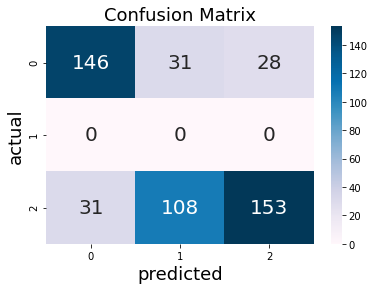

In [11]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()
lr_clf = lr.fit(vect_X, y_train)
y_lr_pred = lr_clf.predict(vectr.transform(X_test))
evaluation(y_lr_pred, y_test)

### SVM

Recall:  0.3987168396770473
Accuracy:  0.5835010060362174
Precision:  0.5400214335507902
F1:  0.45612968591691994


C:\Users\Vivian\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


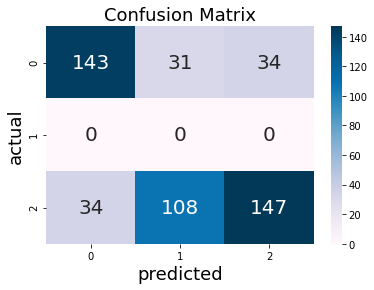

In [12]:
from sklearn.svm import LinearSVC

svm = LinearSVC()
svm_clf = svm.fit(vect_X, y_train)
y_svm_pred = svm_clf.predict(vectr.transform(X_test))
evaluation(y_svm_pred, y_test)

In [30]:
cleaned_twitter = pd.read_csv("./data/cleaned_twitter.csv", index_col=0)
tweets = cleaned_twitter['CleanText']
print(len(tweets))
tweets = tweets.dropna(axis=0, how='any')
print(len(tweets))
tweets = tweets.apply(pre_processing)
tweets

42613
42540


0        flying entourage w jeff parish surveying downe...
1                     air operation underway grand isle la
2        i signed volunteer helping man cooling station...
3        new york ag suggests emergency housing basemen...
4                                             dammit bobby
                               ...                        
65528    forecast td nine become saturday explicitly sh...
65529    it first official advisory likely opinion beco...
65530    btw upgraded will probably within next couple ...
65531                                          sorry sorry
65532    tomorrow year anniversary faced another storm ...
Name: CleanText, Length: 42540, dtype: object

In [31]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectr2 = TfidfVectorizer(ngram_range=(1,2), min_df = 1)
vectr2.fit(tweets)
vect_tweets = vectr.transform(tweets)

In [32]:
y_lr_pred = lr_clf.predict(vect_tweets)

In [33]:
y_lr_pred

array([0, 4, 4, ..., 4, 0, 4], dtype=int64)

In [36]:

cleaned_twitter = cleaned_twitter[cleaned_twitter['CleanText'].notna()]
cleaned_twitter['Sentiment140_Sentiment'] = y_lr_pred

In [38]:
cleaned_twitter.to_csv("./data/sentiment140_sentiment.csv")